### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from itertools import islice
from collections import Counter
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Dropout, GlobalMaxPooling1D
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout, VBox
from IPython.display import display, clear_output
import numpy as np

### Import data

In [2]:
# ISOT Fake News Dataset
# Link Download: https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/

df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [3]:
df_fake["class"] = 0
df_true["class"] = 1
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [4]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [5]:
df_merge.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

## Remove unnecessary columns

In [6]:
df = df_merge.drop(["title", "subject", "date"], axis = 1)

In [7]:
df.columns

Index(['text', 'class'], dtype='object')

### Shuffle data sets randomly

In [8]:
#trộn bộ dữ liệu ngẫu nhiên
df = df.sample(frac = 1)

In [9]:
df.head()

,text,class
12876,The Obama administration is maneuvering to pay...,0
6441,TBILISI (Reuters) - The Trump Organization pul...,1
597,"WASHINGTON (Reuters) - From Pataskala, Ohio, t...",1
20933,"Thank God she has a vagina, otherwise her blat...",0
6222,WASHINGTON (Reuters) - President Barack Obama ...,1


In [10]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

,text,class
0,The Obama administration is maneuvering to pay...,0
1,TBILISI (Reuters) - The Trump Organization pul...,1
2,"WASHINGTON (Reuters) - From Pataskala, Ohio, t...",1
3,"Thank God she has a vagina, otherwise her blat...",0
4,WASHINGTON (Reuters) - President Barack Obama ...,1


### Remove stop words

In [11]:
def wordopt(text):
    text = text.lower()
    text = re.sub('[.*?]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\\S+|www\\.\\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\\w*\\d\\w*', '', text)
    return text

In [12]:
type(df["text"])

pandas.core.series.Series

In [13]:
df["text"] = df["text"].apply(wordopt)

## Create data train (70%) and data test (30%)

In [14]:
x = df["text"]
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [15]:
type(x_train)

pandas.core.series.Series

In [16]:
train_sentences = x_train.to_numpy()
train_labels = y_train.to_numpy()

test_sentences = x_test.to_numpy()
test_labels = y_test.to_numpy()

### Create vocabulary for train labels and test labels

In [17]:
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

### Re-check the correctness of the train labels

In [18]:
train_labels[0]

0

### Convert text to numeric string (index)

In [19]:
vocab_size = 30000 # size
embedding_dim = 300 # dimension number
max_len = 1000 # length
tokenizer = Tokenizer(
    num_words=vocab_size, 
    oov_token="<OOV>"
) # Embed vocabulary tokens
tokenizer.fit_on_texts(train_sentences)


### Print out the number of sentences from the data set

In [20]:
num=len(tokenizer.word_index)
print(num)

144648


### Get the list of words and corresponding integers from the tokenizer

In [21]:
word_index_items = list(tokenizer.word_index.items())

### Check if there are at least 201 words in the tokenizer

In [22]:
print(len(word_index_items))
if len(word_index_items) >= 201:
    word_201, index_201 = word_index_items[200]
    print(f"The 201st word in the tokenizer is: '{word_201}', has an integer of: {index_201}")
else:
    print("Tokenizer does not have 201 words.")


144648
The 201st word in the tokenizer is: 'go', has an integer of: 201


In [23]:
tokenizer.word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 'and': 6,
 'in': 7,
 'that': 8,
 's': 9,
 'on': 10,
 'for': 11,
 'is': 12,
 'he': 13,
 'trump': 14,
 'said': 15,
 'it': 16,
 'with': 17,
 'was': 18,
 'as': 19,
 'his': 20,
 'by': 21,
 'has': 22,
 'be': 23,
 'have': 24,
 'not': 25,
 'from': 26,
 'this': 27,
 'at': 28,
 'are': 29,
 'who': 30,
 'an': 31,
 'they': 32,
 'us': 33,
 'i': 34,
 'we': 35,
 'but': 36,
 'would': 37,
 'president': 38,
 'about': 39,
 't': 40,
 'will': 41,
 'their': 42,
 'had': 43,
 'you': 44,
 'been': 45,
 'people': 46,
 'were': 47,
 'or': 48,
 'more': 49,
 'which': 50,
 'she': 51,
 'one': 52,
 'her': 53,
 'after': 54,
 'if': 55,
 'all': 56,
 'out': 57,
 'state': 58,
 'what': 59,
 'when': 60,
 'its': 61,
 'also': 62,
 'new': 63,
 'up': 64,
 'there': 65,
 'no': 66,
 'reuters': 67,
 'clinton': 68,
 'over': 69,
 'government': 70,
 'donald': 71,
 'obama': 72,
 'our': 73,
 'house': 74,
 'so': 75,
 'can': 76,
 'states': 77,
 'republican': 78,
 'than': 79,
 'other': 80,

### Check to see if the document has been processed yet

In [24]:
new_texts = ["elections doing run robotterror"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
print(new_sequences)

[[590, 411, 407, 1]]


### Number of words in the dictionary

In [25]:
num_words_in_dictionary = len(tokenizer.word_index)
print(num_words_in_dictionary)

144648


### Calculate the frequency of each word in the training data

In [26]:
word_frequencies = Counter(" ".join(train_sentences).split())
print(word_frequencies)

Counter({'the': 709284, 'to': 376184, 'of': 309533, 'a': 287635, 'and': 286139, 'in': 244459, 'that': 166965, 's': 162522, 'on': 133251, 'for': 120813, 'is': 116471, 'he': 92170, 'trump': 91524, 'said': 91197, 'it': 90267, 'with': 82264, 'was': 81225, 'as': 72565, 'his': 67626, 'by': 67125, 'has': 62214, 'be': 57937, 'have': 57936, 'not': 56856, 'from': 56516, 'this': 53867, 'at': 52477, 'are': 50815, 'who': 49069, 'an': 47419, 'they': 46973, 'us': 46332, 'i': 42455, 'we': 42200, 'but': 40563, 'would': 38797, 'president': 38285, 'about': 35504, 't': 35126, 'will': 34340, 'their': 33134, 'had': 32313, 'you': 32169, 'been': 29895, 'people': 28980, 'were': 28237, 'or': 27959, 'more': 27860, 'which': 26870, 'she': 26345, 'one': 25974, 'her': 25540, 'after': 25381, 'if': 24278, 'all': 24121, 'out': 24059, 'state': 23710, 'what': 23046, 'when': 22302, 'its': 21826, 'also': 21789, 'new': 21721, 'up': 21647, 'there': 21377, 'no': 20597, 'reuters': 20577, 'clinton': 19715, 'over': 19672, 'gover

### Print out the dictionary with the frequency from 20000 to 21000

In [27]:
start_index, end_index = 20000, 21000
for word, index in islice(tokenizer.word_index.items(), start_index, end_index):
    frequency = word_frequencies[word] if word in word_frequencies else 0
    print(f"{word}: {index} - Tần suất xuất hiện: {frequency}")

stymie: 20001 - Tần suất xuất hiện: 18
sparse: 20002 - Tần suất xuất hiện: 18
wrestled: 20003 - Tần suất xuất hiện: 18
discontinued: 20004 - Tần suất xuất hiện: 18
ags: 20005 - Tần suất xuất hiện: 18
herethe: 20006 - Tần suất xuất hiện: 18
stumbles: 20007 - Tần suất xuất hiện: 18
percentages: 20008 - Tần suất xuất hiện: 18
cfdt: 20009 - Tần suất xuất hiện: 18
aggravating: 20010 - Tần suất xuất hiện: 18
understated: 20011 - Tần suất xuất hiện: 18
punks: 20012 - Tần suất xuất hiện: 18
daimler: 20013 - Tần suất xuất hiện: 18
ol: 20014 - Tần suất xuất hiện: 18
sighted: 20015 - Tần suất xuất hiện: 18
miraculously: 20016 - Tần suất xuất hiện: 18
joesley: 20017 - Tần suất xuất hiện: 18
pretense: 20018 - Tần suất xuất hiện: 18
pataki: 20019 - Tần suất xuất hiện: 18
wellesley: 20020 - Tần suất xuất hiện: 18
straddling: 20021 - Tần suất xuất hiện: 18
tanden: 20022 - Tần suất xuất hiện: 18
occult: 20023 - Tần suất xuất hiện: 18
lithium: 20024 - Tần suất xuất hiện: 18
itthis: 20025 - Tần suất xuất

### Get the data processed in the above step into the training set

In [28]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
padded_train_sequences = pad_sequences(
    train_sequences, 
    maxlen = max_len,
    truncating='post', 
    padding = 'post'
)

### Get the data processed in the above step into the test set

In [29]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
padded_test_sequences = pad_sequences(
    test_sequences, 
    maxlen = max_len, 
    truncating='post', 
    padding = 'post'
)

### Constants in model

In [30]:
filters = 64
kernel_size = 3
pool_size = 2
lstm_units = 128
rnn_units = 64
dropout_rate = 0.5
num_filters = 32


### Model CNN

In [31]:
# Model
model = Sequential()

# Word embedding layer
model.add(
    Embedding(
        input_dim = vocab_size, 
        output_dim = embedding_dim,
        input_shape=(max_len,)
    )
)

# Convolution and pooling layers
model.add(
    Conv1D(
        filters = filters, 
        kernel_size = 3, 
        activation = 'relu'
    )
)
model.add(GlobalMaxPooling1D())

# Fully Connected layer
model.add(
    Dense(
        128, 
        activation = 'relu'
    )
)
model.add(
    Dropout(
        dropout_rate
    )
)

# Output layer
model.add(
    Dense(
        1, 
        activation = 'sigmoid'
    )
)

# Model compilation
model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

model.summary()

g:\app\python\Lib\site-packages\keras\src\layers\core\embedding.py:89: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 300)      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 998, 64)        │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,066,113 (34.58 MB)

 Trainable params: 9,066,113 (34.58 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train model
history = model.fit(
    padded_train_sequences, 
    train_labels,
    batch_size = 512,
    epochs = 5, 
    validation_data = (padded_test_sequences, test_labels)
)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8372 - loss: 0.4150 - val_accuracy: 0.9947 - val_loss: 0.0208
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9947 - loss: 0.0198 - val_accuracy: 0.9970 - val_loss: 0.0104
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9980 - loss: 0.0083 - val_accuracy: 0.9981 - val_loss: 0.0064
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9988 - loss: 0.0043 - val_accuracy: 0.9986 - val_loss: 0.0054
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9990 - val_loss: 0.0047


In [33]:
# model.save('output/model.keras')

<Figure size 1000x1000 with 0 Axes>

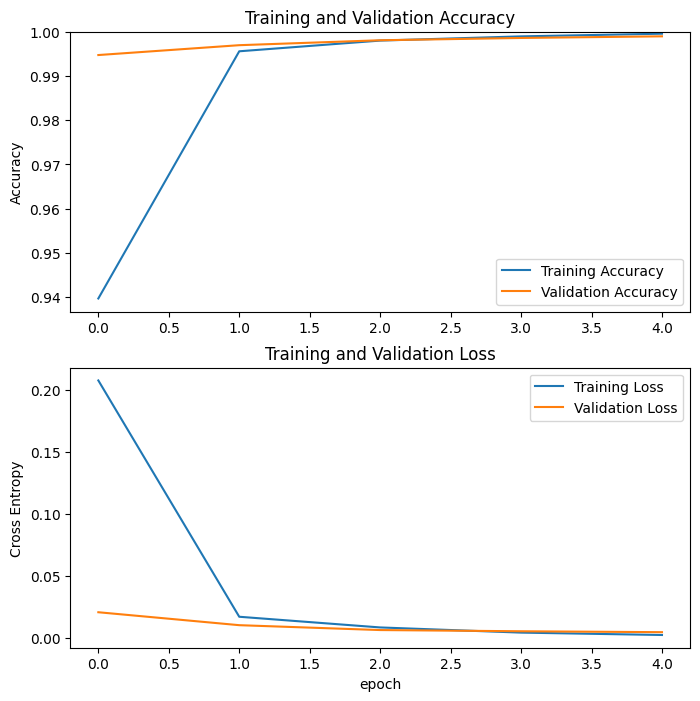

In [34]:


plt.figure(figsize=(10, 10))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend (loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend (loc='upper right')
plt.ylabel('Cross Entropy')
plt.title( 'Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Predictions on new data - REAL NEWS

In [35]:
new_texts = ["BRUSSELS (Reuters) - NATO allies on Tuesday welcomed President Donald Trump s decision to commit more forces to Afghanistan, as part of a new U.S. strategy he said would require more troops and funding from America s partners. Having run for the White House last year on a pledge to withdraw swiftly from Afghanistan, Trump reversed course on Monday and promised a stepped-up military campaign against  Taliban insurgents, saying:  Our troops will fight to win .  U.S. officials said he had signed off on plans to send about 4,000 more U.S. troops to add to the roughly 8,400 now deployed in Afghanistan. But his speech did not define benchmarks for successfully ending the war that began with the U.S.-led invasion of Afghanistan in 2001, and which he acknowledged had required an   extraordinary sacrifice of blood and treasure .  We will ask our NATO allies and global partners to support our new strategy, with additional troops and funding increases in line with our own. We are confident they will,  Trump said. That comment signaled he would further increase pressure on U.S. partners who have already been jolted by his repeated demands to step up their contributions to NATO and his description of the alliance as  obsolete  - even though, since taking office, he has said this is no longer the case. NATO Secretary General Jens Stoltenberg said in a statement:  NATO remains fully committed to Afghanistan and I am looking forward to discussing the way ahead with (Defense) Secretary (James) Mattis and our Allies and international partners.  NATO has 12,000 troops in Afghanistan, and 15 countries have pledged more, Stoltenberg said. Britain, a leading NATO member, called the U.S. commitment  very welcome .  In my call with Secretary Mattis yesterday we agreed that despite the challenges, we have to stay the course in Afghanistan to help build up its fragile democracy and reduce the terrorist threat to the West,  Defence Secretary Michael Fallon said. Germany, which has borne the brunt of Trump s criticism over  the scale of its defense spending, also welcomed the new U.S. plan.  Our continued commitment is necessary on the path to stabilizing the country,  a government spokeswoman said. In June, European allies had already pledged more troops but had not given details on numbers, waiting for the Trump administration to outline its strategy for the region.Nearly 16 years after the U.S.-led invasion - a response to the Sept. 11 attacks which were planned by al Qaeda leader Osama bin Laden from Afghanistan - the country is still struggling with weak central government and a Taliban insurgency. Trump said he shared the frustration of the American people who were  weary of war without victory , but a hasty withdrawal would create a vacuum for groups like Islamic State and al Qaeda to fill."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(
    new_sequences, 
    maxlen = max_len, 
    padding = 'post'
)

predictions = model.predict(new_padded_sequences)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predictions: [[0.9999953]]


### Prediction on new data - FAKE NEWS

In [36]:
new_texts = ["Vic Bishop Waking TimesOur reality is carefully constructed by powerful corporate, political and special interest sources in order to covertly sway public opinion. Blatant lies are often televised regarding terrorism, food, war, health, etc. They are fashioned to sway public opinion and condition viewers to accept what have become destructive societal norms.The practice of manipulating and controlling public opinion with distorted media messages has become so common that there is a whole industry formed around this. The entire role of this brainwashing industry is to figure out how to spin information to journalists, similar to the lobbying of government. It is never really clear just how much truth the journalists receive because the news industry has become complacent. The messages that it presents are shaped by corporate powers who often spend millions on advertising with the six conglomerates that own 90% of the media:General Electric (GE), News-Corp, Disney, Viacom, Time Warner, and CBS. Yet, these corporations function under many different brands, such as FOX, ABC, CNN, Comcast, Wall Street Journal, etc, giving people the perception of choice   As Tavistock s researchers showed, it was important that the victims of mass brainwashing not be aware that their environment was being controlled; there should thus be a vast number of sources for information, whose messages could be varied slightly, so as to mask the sense of external control. ~ Specialist of mass brainwashing, L. WolfeNew Brainwashing Tactic Called AstroturfWith alternative media on the rise, the propaganda machine continues to expand. Below is a video of Sharyl Attkisson, investigative reporter with CBS, during which she explains how  astroturf,  or fake grassroots movements, are used to spin information not only to influence journalists but to sway public opinion. Astroturf is a perversion of grassroots. Astroturf is when political, corporate or other special interests disguise themselves and publish blogs, start facebook and twitter accounts, publish ads, letters to the editor, or simply post comments online, to try to fool you into thinking an independent or grassroots movement is speaking. ~ Sharyl Attkisson, Investigative ReporterHow do you separate fact from fiction? Sharyl Attkisson finishes her talk with some insights on how to identify signs of propaganda and astroturfing  These methods are used to give people the impression that there is widespread support for an agenda, when, in reality, one may not exist. Astroturf tactics are also used to discredit or criticize those that disagree with certain agendas, using stereotypical names such as conspiracy theorist or quack. When in fact when someone dares to reveal the truth or questions the  official  story, it should spark a deeper curiosity and encourage further scrutiny of the information.This article (Journalist Reveals Tactics Brainwashing Industry Uses to Manipulate the Public) was originally created and published by Waking Times and is published here under a Creative Commons license with attribution to Vic Bishop and WakingTimes.com. It may be re-posted freely with proper attribution, author bio, and this copyright statement. READ MORE MSM PROPAGANDA NEWS AT: 21st Century Wire MSM Watch Files"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(
    new_sequences, 
    maxlen = max_len, 
    padding = 'post'
)

predictions = model.predict(new_padded_sequences)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predictions: [[1.6233026e-06]]


### Test predict

In [37]:
new_texts = ["Question dr ron paul outer limit radio dr paul serve twelve term u house representative threetime candidate u president devote political career defense individual liberty sound money noninterventionist foreign policy judge andrew napolitano call thomas jefferson day serve flight surgeon u air force dr paul move texas begin civilian medical practice deliver four thousand baby career obstetrician dr paul serve congress carol paul wife fifty year five child many grandchild greatgrandchildren ron paul new york post write politician buy special interest people public life thick thin rain shine stick principles added congressional colleague ron paul one ron paul never vote legislation unless propose measure expressly authorize constitution also congressman ron paul never vote raise tax ron paul never vote unbalanced budget ron paul never vote federal restriction gun ownership ron paul never vote raise congressional pay ron paul never take governmentpaid junket ron paul never vote increase power executive branch ron paul vote patriot act ron paul vote regulate internet ron paul vote iraq war ron paul participate lucrative congressional pension program ron paul chairman ron paul institute peace prosperity nonprofit educational charity host daily ron paul liberty report special thanks daniel mcadams chris rossini dylan charles chris duane mp audio link please check dr paul late book revolution ten year learn out limit radio website"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(
    new_sequences, 
    maxlen=max_len, 
    padding='post'
)

predictions = model.predict(new_padded_sequences)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions: [[0.00059669]]


### Test predict

In [38]:
new_texts = ["Suge knight claim tupac still alive twentyone year ago legendary u rapper tupac amaru shakur die shot street la vega september since conspiracy theory image repeatedly emerge prove rapper still alive man sit car tupac shot fire speaks make bizarre story year interview american tv station fox music mogul suge explain life imprisonment murder explain former best friend live anymore suge knight interview leave hospital pac laugh make joke ca nt understand someone state health change good bad ask believe rapper still alive suge reply tell never know pac people believe death incidentally music mogul alone opinion tupac shakur could still alive former policeman recently claim pay million euro fake tupac death official put follow word record world need know do ashamed exchange honesty money ca nt die without world knowing include popular story tupac tupac life cuba godmother political activist assata olugbala shakur suge knight kill tupac tupac back rapper kasinova tha spread music p diddy notorious big order tupac murder tupac member illuminati illuminati kill tupac become powerful tupac abducted alien fbi kill tupac related article suge knight finally admit tupac alive video elvis presley alive people convince elvis alive new photo emerge"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(
    new_sequences, 
    maxlen = max_len, 
    padding = 'post'
)

predictions = model.predict(new_padded_sequences)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predictions: [[3.0451718e-05]]


### Test predict

In [39]:
new_texts = ["Senate Majority Whip John Cornyn (R-TX) thought it would be a good idea to attack Special Counsel Robert Mueller over the Russia probe. As Mueller s noose tightens, Republicans are losing their sh-t and attacking Mueller and the FBI in order to protect probably the most corrupt  president  ever.Former Attorney General Eric Holder tweeted on Friday,  Speaking on behalf of the vast majority of the American people, Republicans in Congress be forewarned: any attempt to remove Bob Mueller will not be tolerated. Cornyn retweeted Holder to say,  You don t. You don t https://t.co/7lHYkIloyz  Senator JohnCornyn (@JohnCornyn) December 16, 2017Bloomberg s Steven Dennis tweeted on Saturday that  [Cornyn] s beef is with Holder, not Mueller,  but Cornyn responded to say,  But Mueller needs to clean house of partisans. But Mueller needs to clean house of partisans https://t.co/g8SwgAKtfH  Senator JohnCornyn (@JohnCornyn) December 16, 2017The Washington Post s Greg Sargent asked Cornyn,  Will you accept the findings of the Mueller probe as legitimate, @JohnCornyn? Makes sense to me to wait to see what they are first,  Cornyn responded.Makes sense to me to wait to see what they are first https://t.co/9lCqpYujKN  Senator JohnCornyn (@JohnCornyn) December 16, 2017Republicans are trying to discredit Mueller and Twitter users took notice.If you even THINK of firing Mueller I ll make it my life s mission to make sure this is your last term, buddy.  Mrs. SMH (@MRSSMH2) December 16, 2017Carrollton, TX here Ready and willing to help get Cruz and Cornyn out  Jules012 (@JulesLorey1) December 16, 2017Garland, TX here Same! Bye Bye   TDK (@ejkmom1998) December 16, 2017Austin, TX. #IStandWithMueller. Cronyn is a fake representative. He represents his own interests and anything to profit himself  Vj (@Tex92eye) December 16, 2017I stand with Mueller!   Kenneth Shipp (@shipp_kenneth) December 16, 2017He speaks for me Its BS how you cover up for a Russia pawn If Trump not gulity why would Mueller be fired to cover up  Ellen Reeher Morris (@EllenMorris1222) December 16, 2017@EricHolder speaks for 69% of Americans according to recent polling. That s  vast majority  in my book. You were around for the Saturday Night Massacre @JohnCornyn. Firing Mueller would be X100!  Lori Winters (@LoriW66) December 16, 2017Country over party. pic.twitter.com/NXEX9rGBgu  PittieBoo (@PittieBoo) December 16, 2017He speaks for me, @JohnCornyn , and he speaks for the vast majority of American citizens who, you should remember, vote. See you in 2018.  Andrew Silver (@standsagreenoak) December 16, 2017I might just move to Texas to get those cronies tossed out of office. Blue wave is coming for the corrupt.  Ollie (@marciebp) December 16, 2017Good try, John. History will not be kind to you.Photo by Ann Heisenfelt/Getty Images"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(
    new_sequences, 
    maxlen=max_len, 
    padding='post'
)

predictions = model.predict(new_padded_sequences)
print("Predictions:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predictions: [[3.3376575e-05]]


In [40]:
type(padded_train_sequences[0])

numpy.ndarray

### The function checks the article

In [41]:
def check_article(text):
    new_texts = [text]
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded_sequences = pad_sequences(
        new_sequences, 
        maxlen=max_len, 
        padding='post'
    )

    predictions = model.predict(new_padded_sequences)
    print("Predictions:", predictions)
    if predictions[0][0] > 0.5:
        confidence = predictions[0][0] * 100
        return f"The above information is true ({confidence:.2f}%)"
    else:
        confidence = ( predictions[0][0]) * 100
        return f"The above information is false ({confidence:.2f}%)"

# Tạo trường nhập văn bản
text_input = widgets.Text(
    placeholder='Enter article text', 
    layout=Layout(
        width='70%',
        margin='0 auto 10px auto'
    )
)

# Create a "Check Article" button
check_button = widgets.Button(
    description='Check out the article', 
    button_style='success', 
    layout=Layout(
        width='20%', 
        margin='0 auto 10px auto'
    )
)

# Create a label that displays the results
result_label = widgets.HTML(
    value='', 
    layout=Layout(margin='20px')
)

# The function handles the event when the button is pressed
def on_button_click(b):
    result = check_article(text_input.value)
    result_label.value = result

    # Draw a simple chart
    fig, ax = plt.subplots()
    ax.plot([1, 2, 3, 4], [10, 20, 25, 30], label='Dữ liệu mẫu')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Biểu đồ đơn giản')
    ax.legend()

    # Display the chart in VBox
    with out:
        clear_output(wait=True)
        plt.show()

# Bind the event handler function to the button click event
check_button.on_click(on_button_click)

# Create a VBox with a rectangular outline and white background color
vbox = VBox(
    [
        text_input, 
        check_button, 
        result_label
    ], 
    layout=Layout(
        width='50%',
        margin='0 auto',
        border='2px solid #000', 
        background_color='#fff', 
        align_items='center', 
        justify_content='center'
    )
)

# Create an output widget to display the chart
out = widgets.Output(
    layout={
        'border': '1px solid black', 
        'height': '300px', 
        'margin': '0 auto'
    }
)

# Add output widget to VBox
vbox.children += (out,)

# Set background color for entire VBox
vbox.layout.background_color = '#fff'

# Display VBox
display(vbox)
